In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.utils import random
from sklearn.model_selection import train_test_split

from collections import OrderedDict

combined_data = pd.read_hdf("../source_files/combined_data_C1.hdf5")

INPUT_COLUMNS = ["start_speed", "spin_rate", "spin_dir", "zone", "pitch_type"]
CONTEXT_COLUMNS = ["b_score", "p_score", "b_count", "s_count", "outs", "pitch_num", \
    "on_1b", "on_2b", "on_3b", "inning", "p_throws", "stand", "top"]
OUTPUT_COLUMNS = ["at_bat_score"]

inputs = combined_data[INPUT_COLUMNS].copy()
context = combined_data[CONTEXT_COLUMNS].copy()

#------------- One-Hot Encode  -----------------
inputs = pd.concat([inputs, pd.get_dummies(inputs.pitch_type)], axis=1)
inputs = inputs.drop(labels="pitch_type", axis=1)

context[["p_throws", "stand"]] = context[["p_throws", "stand"]] == "R"
context[["p_throws", "stand", "top"]] = context[["p_throws", "stand", "top"]].astype(int)
context = context.rename(columns={"p_throws":"p_isrighty", "stand":"b_isrighty", "top":"is_top_inning"})

combined_inputs = pd.concat([inputs, context], axis=1)

nn_data = pd.concat([combined_inputs, combined_data[OUTPUT_COLUMNS]], axis=1)
nn_data.to_hdf("../source_files/model_data.hdf5", key="df")

combined_inputs = torch.tensor(combined_inputs.values)
outputs = torch.tensor(combined_data[OUTPUT_COLUMNS].values)



In [51]:
class FFNetPytorch(nn.Module):
  def __init__(self, input_size, output_size, hl1=100, hl2=25):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hl1, bias = True)
    self.layer2 = nn.Linear(hl1, hl2, bias = True)
    self.layer3 = nn.Linear(hl2, output_size, bias=True)

    self.double()
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.sigmoid(self.layer1(x))
    x = torch.sigmoid(self.layer2(x))
    x = self.layer3(x)

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i, ...], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


Training

In [68]:
#------------- Train --------------
X_train, X_test, Y_train, Y_test = \
    train_test_split(combined_inputs, outputs, test_size=0.2, random_state=42)

NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 1

HIDDEN1_SIZE = 100
HIDDEN2_SIZE = 25

batch_size = 512
max_epochs = 30

print_every = 1
test_every = 1
SAVE_EVERY = 10

LR = 1e-3


SAVE_MODEL = True
LOAD_MODEL = True
SAVE_PATH = "HL2_100_25_TL1e3_decay"
MODEL_SAVE_PATH = "models/" + SAVE_PATH + ".pt"
TRAIN_LOSSES_SAVE_PATH = "trainingloss/" + SAVE_PATH + ".csv"
TEST_LOSSES_SAVE_PATH = "testloss/" + SAVE_PATH + ".csv"
ACCURACY_SAVE_PATH = "accuracies/" + SAVE_PATH + ".csv"

CONV_SIZE = 20 #CONVERGENCE_WINDOW_SIZE
CONVERGENCE_THRESHOLD = 0.01

model = FFNetPytorch(NUM_FEATURES, NUM_CLASSES, hl1=HIDDEN1_SIZE, hl2=HIDDEN2_SIZE)
train_losses =[]
test_losses=[]
train_accuracies = []

if LOAD_MODEL:
    try:
      model = torch.load(MODEL_SAVE_PATH)
      train_losses = np.fromfile(TRAIN_LOSSES_SAVE_PATH, sep=',').tolist()
      test_losses = np.fromfile(TEST_LOSSES_SAVE_PATH, sep=',').tolist()
      train_accuracies = np.fromfile(ACCURACY_SAVE_PATH, sep=',').tolist()
    except FileNotFoundError:
      pass
  
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.25)
loss_fn = nn.MSELoss()
#torch.manual_seed(314159)
device = "cpu"

dataset_train = CustomDataset(X_train, Y_train)
dataset_test = CustomDataset(X_test, Y_test)

model = model.to(device)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

accuracies = []
total_epochs = max_epochs + len(train_losses)
for epoch in range(len(train_losses), total_epochs):  
  batch_losses = []
  batch_accuracies = []
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    prediction = torch.round(output)
    accuracy = torch.sum(prediction == target)/len(target)
    loss.backward()
    optimizer.step()
    batch_losses.append(loss.item())
    batch_accuracies.append(accuracy.item())
  
  if epoch > 3: scheduler.step()
  test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).item()
  accuracies.append(test_accuracy)
  train_losses.append(torch.mean(torch.Tensor(batch_losses)).item())
  train_dif = (np.max(train_losses[-CONV_SIZE:])-np.min(train_losses[-CONV_SIZE:]))/np.mean(train_losses[-CONV_SIZE:])

  model.eval()
  batch_losses = []

  if epoch % test_every == 0:
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = loss_fn(output, target)
      batch_losses.append(loss.item())

    test_losses.append(torch.mean(torch.Tensor(batch_losses)).item())

  if epoch % SAVE_EVERY == 0:
    print("----- SAVED -----")
    torch.save(model, MODEL_SAVE_PATH)
    np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
    np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
    np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')

  if epoch % print_every == 0:
    print('{epoch}/{max_epoch}, Train Loss: {loss:.6f}, Test Loss: {test_loss:.6f}, Accuracy: {accuracy:.4f}%, Difference {diff:.3f}%, lr: {lr}'.format(
                epoch=epoch, max_epoch=total_epochs, loss=train_losses[-1], test_loss=test_losses[-1], \
                accuracy = test_accuracy*100, diff=train_dif*100, lr=scheduler.get_last_lr()[0]))

if SAVE_MODEL:
  torch.save(model, MODEL_SAVE_PATH)
  np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
  np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
  np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')
  


FFNetPytorch(
  (layer1): Linear(in_features=27, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=25, bias=True)
  (layer3): Linear(in_features=25, out_features=1, bias=True)
)
----- SAVED -----
0/30, Train Loss: 3.279654, Test Loss: 3.159185, Accuracy: 5.4499%, Difference 0.000%, lr: 0.001
1/30, Train Loss: 3.161458, Test Loss: 3.170485, Accuracy: 19.1337%, Difference 3.670%, lr: 0.001
2/30, Train Loss: 3.162199, Test Loss: 3.170693, Accuracy: 19.0722%, Difference 3.692%, lr: 0.001
3/30, Train Loss: 3.158464, Test Loss: 3.161782, Accuracy: 19.3481%, Difference 3.799%, lr: 0.001


KeyboardInterrupt: 

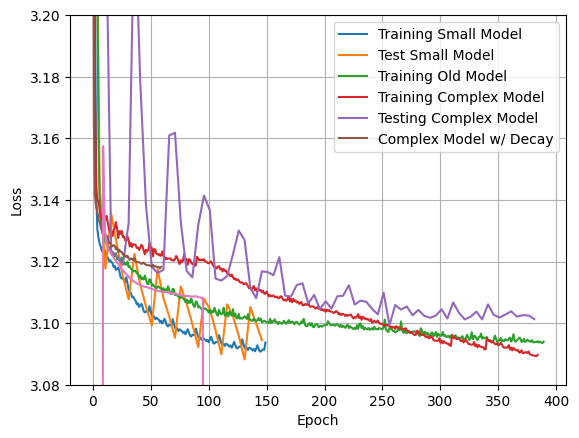

In [30]:
import matplotlib.pyplot as plt


train_losses = np.fromfile("trainingloss/HL1_100_TL1E4.CSV", sep=',').tolist()
test_losses = np.fromfile("testloss/HL1_100_TL1E4.CSV", sep=',').tolist()
old_loss = np.fromfile("models/losses1e4.csv", sep=',').tolist()
complex_model = np.fromfile("trainingloss/largenetwork.csv", sep=',').tolist()
complex_model_test = np.fromfile("testloss/largenetwork.csv", sep=',').tolist()
complex_model_decay = np.fromfile("trainingloss/largenetwork_decay.csv", sep=',').tolist()
new_model = np.fromfile("trainingloss/HL1.csv", sep=',').tolist()
new_model_test = np.fromfile("testloss/HL1.csv", sep=',').tolist()

kernal_size = 10
kernal = np.ones(kernal_size)/kernal_size
new_model = np.convolve(new_model, kernal)
new_model_test = np.convolve(new_model_test, kernal)


plt.figure()
plt.plot(train_losses)
plt.plot(np.arange(1, len(train_losses), 5), test_losses)
plt.plot(old_loss)
plt.plot(complex_model)
plt.plot(np.arange(1, len(complex_model), 5), complex_model_test)
plt.plot(complex_model_decay)
plt.plot(new_model)
#plt.plot(new_model_test)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(3.08, 3.2)
plt.grid()
plt.legend(["Training Small Model", "Test Small Model", "Training Old Model", "Training Complex Model", \
    "Testing Complex Model", "Complex Model w/ Decay"])
plt.show()

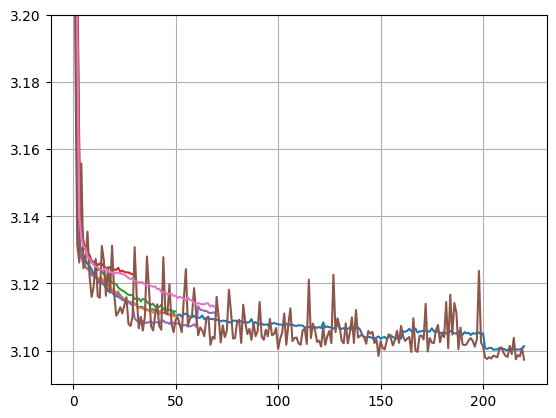

In [63]:
hl2_100_25_train = np.fromfile("trainingloss/HL2_100_25.csv", sep=',').tolist()
hl2_100_25_test = np.fromfile("testloss/HL2_100_25.csv", sep=',').tolist()
hl1_100_train = np.fromfile("trainingloss/HL1_100.csv", sep=',').tolist() 
hl1_100_test = np.fromfile("testloss/HL1_100.csv", sep=',').tolist() 
hl1_50_train = np.fromfile("trainingloss/HL1_50.csv", sep=',').tolist() 
hl1_50_test = np.fromfile("testloss/HL1_50.csv", sep=',').tolist() 

hl1_25_train = np.fromfile("trainingloss/HL1_25.csv", sep=',').tolist()
hl1_200_train = np.fromfile("trainingloss/HL1_200.csv", sep=',').tolist()
plt.figure()
plt.plot(hl2_100_25_train)
plt.plot(hl1_100_train)
plt.plot(hl1_50_train)
plt.plot(hl1_25_train)
plt.plot(hl1_200_train)
#plt.plot(np.fromfile("testloss/HL1_200.csv", sep=',').tolist())
plt.plot(hl2_100_25_test)
plt.plot(np.fromfile("trainingloss/HL2_25_25.csv", sep=',').tolist())
plt.ylim(3.09, 3.2)
plt.grid()
plt.show()
